In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import shuffle
import sklearn.metrics as metrics


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 預處理

In [6]:
data = pd.read_csv("C:/Users/USER/Desktop/Program/IoTPython/Train_Test_IoT_Garage_Door.csv")
for i in range(10):
    data = shuffle(data)
#ts=date+time所以不需要
data.pop("date")
data.pop("time")
#取代空格
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
"""
data["door_state"] = [i.replace(" ","") for i in data['door_state']]
data["sphone_signal"] = [i.replace(" ","") for i in data['sphone_signal']]"""
#labeling
data['door_state'] = data['door_state'].map({"closed":0,"open":1})
data['sphone_signal'] = data["sphone_signal"].map({"false":0,"true":1,"0":0 ,"1":1})

#ts正規化
# 創建 StandardScaler 物件
scaler = StandardScaler()
data["ts"]=scaler.fit_transform(data["ts"].values.reshape(-1, 1))

type_one_hot = pd.get_dummies(data["type"],prefix="type")
data.pop("type")
data = data.join(type_one_hot)

#拿出資料90%當作訓練集
par = np.random.rand(len(data)) < 0.9
data_train = data[par]
#剩下的當作test集
data_test = data[~par]

train_data = data.values
test_data = data.values
#前4列的資料進行訓練
X_train = train_data[:,0:4]
X_train=X_train.astype(float)
#第5列之後為目標變量
Y_train = train_data[:,4:]
Y_train= Y_train.astype(float)
#前4列為測試集
X_test = test_data[:,0:4]
X_test=X_test.astype(float)
#第5列之後為訓練目標變量
Y_test = test_data[:,4:]
Y_test=Y_test.astype(float)

In [8]:
data.head(10)

,ts,door_state,sphone_signal,label,type_backdoor,type_ddos,type_injection,type_normal,type_password,type_ransomware,type_scanning,type_xss
763,1.098480,0,0,1,False,True,False,False,False,False,False,False
5161,1.360948,0,0,1,True,False,False,False,False,False,False,False
29541,1.222570,0,0,1,False,False,False,False,False,False,False,True
51619,-0.877601,0,0,0,False,False,False,True,False,False,False,False
43023,-0.877457,0,0,0,False,False,False,True,False,False,False,False
51264,-0.877607,0,0,0,False,False,False,True,False,False,False,False
17533,1.077352,0,0,1,False,False,True,False,False,False,False,False
24821,1.297917,0,0,1,False,False,False,False,False,True,False,False
39913,-0.877495,0,0,0,False,False,False,True,False,False,False,False
22724,1.175223,0,0,1,False,False,False,False,True,False,False,False


## KNN建置

In [9]:
knnModel = KNeighborsClassifier(n_neighbors=3)
knnModel.fit(X_train,Y_train)
predicted= knnModel.predict(X_train)

## 預測成功的比例

In [10]:
print('訓練集: ',knnModel.score(X_train,Y_train))
print('測試集: ',knnModel.score(X_test,Y_test))

訓練集:  1.0
測試集:  1.0


## KFold驗證 當neighbor=3

In [ ]:
accuracy = cross_val_score(knnModel, X_test, Y_test, cv=10, scoring="accuracy")
print(accuracy)
print(accuracy.mean()*100,'%')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
100.0 %


## 輸出混淆矩陣

In [13]:
Y_pred = predicted

Y_pred = np.argmax(Y_pred, axis=1).astype(int)
Y_test_2 = np.argmax(Y_test, axis=1).astype(int)


from sklearn.metrics import multilabel_confusion_matrix

#row=Y_test_2 col=Y_pred
cm=confusion_matrix(Y_test_2,Y_pred)
print(cm)

[[ 5000     0     0     0     0     0     0     0]
 [    0  5000     0     0     0     0     0     0]
 [    0     0  5000     0     0     0     0     0]
 [    0     0     0 35000     0     0     0     0]
 [    0     0     0     0  5000     0     0     0]
 [    0     0     0     0     0  2902     0     0]
 [    0     0     0     0     0     0   529     0]
 [    0     0     0     0     0     0     0  1156]]


## 繪製熱力圖

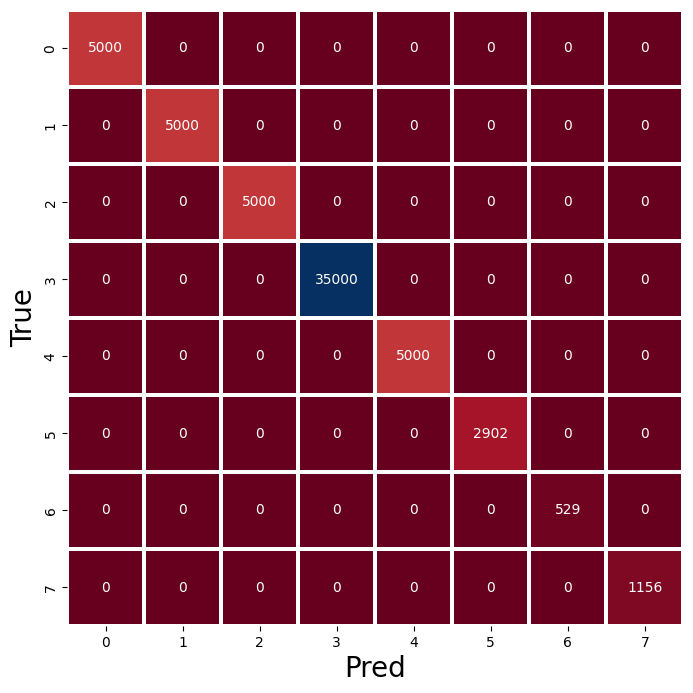

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

## KNN最佳值

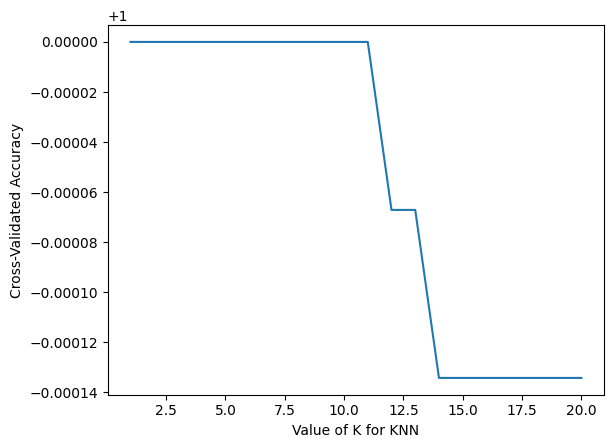

In [ ]:
k_range = range(1,21)
k_scores = []
for k_number in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_number)
    scores = cross_val_score(knn,X_train,Y_train,cv=10,scoring='accuracy')
    k_scores.append(scores.mean())

plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()